In [ ]:
Шаги по обучению:

1. Структуризация датасета в виде набора группированных по классам вопросов.
2. Проход по датасету, где X - вопрос, Y - порядковый номер группы.
3. Для каждого X исправлять ошибки, лемматизировать и векторизовать.
4. Поиск веса методом обратного градиентного спуска.
5. После прохода по всему датасету вывод точности и сохранение весов.

Будем использовать navec_news. В navec_hudlit нет необходимых нам слов (бакалавриат, магистратура).

In [27]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)
from navec import Navec
import jamspell
import numpy as np
import matplotlib.pyplot as plt

# Посчитаем сколько времени занимает выполнение кода
import time

# Загружаем библиотеки Natasha и Jamspell
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

# https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
# https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
# navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
navec = Navec.load('navec_news_v1_1B_250K_300d_100q.tar')

corrector = jamspell.TSpellCorrector()
# https://github.com/bakwc/JamSpell-models/raw/master/ru.tar.gz
corrector.LoadLangModel('ru_small.bin')

True

In [48]:
def sentence_to_vector(sentence):
    sentence = sentence.replace("ВУЦ", "военный учебный центр") # не умеем работать с аббревиатурами, увы
    sentence = sentence.replace("СГТУ", "Саратовский государственный университет")
    sentence = sentence.replace("сгту", "Саратовский государственный университет")
    text = corrector.FixFragment(sentence)
    doc = Doc(text)
    doc.segment(Segmenter())
    doc.tag_morph(morph_tagger)
    doc.tokens = [token for token in doc.tokens if token.pos not in ['PUNCT', 'NUM', 'PRON', 'ADP', 'CCONJ', 'PART', 'DET', 'SCONJ']]
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    batch = [_.lemma for _ in doc.tokens]
    print(batch)
    vectors = []
    undefined = []
    for word in batch:
        vector = navec.get(word)
        if vector is not None:
            vectors.append(vector)
        else:
            undefined.append(word)
            
    if len(undefined) > 0:
        print("В корпусе не найдены некоторые слова. Это повлияет на точность обучения. Стоит сменить корпус Navec. Не распознаны:", undefined)
            
    return np.sum(vectors, axis=0)

print(sentence_to_vector("ВУЦ при СГТУ"))

['военный', 'учебный', 'центр', 'саратовский', 'государственный', 'университет']
[-1.4517014  -2.2196536  -1.857335    2.069316   -0.48179343  1.816005
  1.1690582  -3.3957045   0.91716075 -0.33247322  1.381592   -0.34687325
  1.4737687   1.1017294   1.6284403   1.6835321  -2.0389433   1.8817518
 -0.05065052 -2.0315876  -1.0738381   0.73976326  0.4550196   1.8977206
  0.8967243   0.44110227 -0.28791776 -0.42199627 -1.1451014   2.8525248
 -3.1364129  -4.075185   -0.86478496  0.06943151  1.4893366   1.2813244
  2.392615    0.02474262  1.6132691   0.9566036  -0.8803216  -0.29583746
 -0.14885384  1.488445   -0.1426333   0.4203251  -2.0894127   2.2377322
 -1.6869849   0.34173307 -0.29685092 -0.68889594  1.1635071   1.5168066
  1.6663383   2.246215    0.34615153  0.8651687  -1.4985905  -0.15080409
 -1.9417038  -1.0652034   0.24509189 -0.40656966  1.2524391  -0.8469243
  0.79267496 -0.3044741  -5.566915    0.5198617   1.0536362  -2.376979
  0.07622859 -0.11610137  1.4860125  -0.48371035  1.71

In [74]:
import json

def load_dataset():
    dataset = []
    limit = 200

    with open('dataset.json', 'r') as f:
        questions = json.load(f)['questions']
        #print(len(questions))
        for i in range(0, len(questions)):
            for question in questions[i]:
                limit -= 1
                #print(limit)
                if limit < 1:
                    return dataset
                
                dataset.append([np.array([sentence_to_vector(question)]), i])
    return dataset
dataset = load_dataset()
print(dataset[0][0][0])

['срок', 'прием', 'документ', 'очный', 'форма', 'бакалавриат']
['срок', 'прием', 'документ', 'очный', 'форма', 'обучение', 'бакалавриат']
['срок', 'прием', 'очный', 'форма', 'бакалавриат']
['срок', 'прием', 'первый', 'курс', 'очный', 'обучение', 'бакалавриат']
['дата', 'прием', 'первый', 'курс', 'очный', 'обучение', 'бакалавриат']
['срок', 'прием', 'первый', 'курс', 'очко', 'бакалавриат']
['дата', 'прием', 'первый', 'курс', 'очко', 'бакалавриат']
['срок', 'прием', 'документ', 'очный', 'форма', 'егэ', 'бакалавриат']
['срок', 'прием', 'очный', 'форма', 'единый', 'государственный', 'экзамен', 'бакалавриат']
['прием', 'очный', 'форма', 'бакалавриат']
['прием', 'очный', 'форма', 'обучение', 'бакалавриат']
['прием', 'очный', 'форма', 'егэ', 'бакалавриат']
['прием', 'очко', 'бакалавриат']
['срок', 'прием', 'очко', 'бакалавриат']
['прием', 'очко', 'бакалавриат']
['прием', 'очный', 'обучение', 'бакалавриат']
['дата', 'прием', 'очный', 'обучение', 'бакалавриат']
['дата', 'прием', 'очко', 'бакала

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

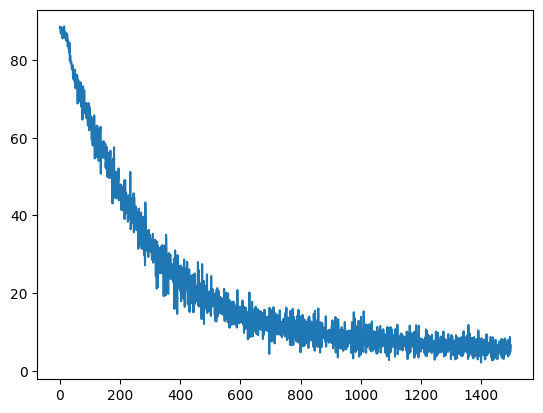

W1: [[-0.07266342  0.03325028  0.00133732 -0.02586098]
 [-0.0060193  -0.06102003 -0.08051991  0.05961324]
 [-0.00135739 -0.05835749 -0.03743595 -0.03789405]
 ...
 [ 0.07411441 -0.04750649  0.03478914 -0.05050029]
 [ 0.19407094 -0.00390535 -0.00681883 -0.00847737]
 [ 0.1633847  -0.06175689  0.00421673  0.00227582]]
b1: [[0.12623427 0.00490615 0.1186174  0.01446276]]
W2: [[-0.89213218  0.64638938 -0.32507212  0.53411758  0.22947196]
 [ 0.84024858 -0.51243826 -0.19536808  0.3369531  -0.46397261]
 [ 0.00918354  0.18506566  0.66304165 -0.6683203   0.21327418]
 [ 0.26060812  0.31298063 -0.41517123 -0.08447642  0.12661143]]
b2: [[-0.54697541 -0.55556898 -0.09372453 -0.1951003   0.153247  ]]


In [75]:
import random
import numpy as np

INPUT_DIM = 300
OUT_DIM = 5
H_DIM = 4


def relu(t):
    return np.maximum(t, 0)


def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)


def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)


def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])


def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))


def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full


def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full


def relu_deriv(t):
    return (t >= 0).astype(float)


W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1 / INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1 / INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1 / H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1 / H_DIM)

ALPHA = 0.0001
NUM_EPOCHS = 500
BATCH_SIZE = 50

loss_arr = []

for ep in range(NUM_EPOCHS):
    print("Epoch:", ep)
    random.shuffle(dataset)
    for i in range(len(dataset) // BATCH_SIZE):
        batch_x, batch_y = zip(*dataset[i * BATCH_SIZE: i * BATCH_SIZE + BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        # Forward
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        # Backward
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Update
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)


def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z


def calc_accuracy():
    correct = 0
    for x, y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc


accuracy = calc_accuracy()
print("Accuracy:", accuracy)

plt.plot(loss_arr)
plt.show()

print("W1:", W1)
print("b1:", b1)
print("W2:", W2)
print("b2:", b2)

with open('model.json', 'w') as f:
    json.dump({
        "W1": W1.tolist(),
        "b1": b1.tolist(),
        "W2": W2.tolist(),
        "b2": b2.tolist()
    }, f)
